In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

Using matplotlib backend: agg


In [2]:
class NaiveConv(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(NaiveConv, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_channel, out_channel),
            torch.nn.Tanh()
        )
        
    def forward(self, x, adj):
        h = self.layers(x)
        x = torch.mm(
            adj,
            h
        )
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()
        
        self.conv1 = NaiveConv(in_channel, 16)
        self.conv2 = NaiveConv(16, out_channel)
        
        injection = torch.randn_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )
        
    def forward(self, data):
        x, adj = data.x, data.adj
        
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
    
        x = self.conv1(x, adj)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'CiteSeer'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
# data.adj = to_dense_adj(data.edge_index)[0]
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=0.001)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
%%time

# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.16666666666666666 , loss = 7.686241149902344
1000 training acc = 1.0 , loss = 0.022518975660204887
2000 training acc = 1.0 , loss = 0.006802028510719538
3000 training acc = 1.0 , loss = 0.0044158995151519775
4000 training acc = 1.0 , loss = 0.0028402647003531456
5000 training acc = 1.0 , loss = 0.0018091241363435984
6000 training acc = 1.0 , loss = 0.0007581492536701262
7000 training acc = 1.0 , loss = 0.0006891469238325953
8000 training acc = 1.0 , loss = 0.0006422817823477089
9000 training acc = 1.0 , loss = 0.0006187717081047595
CPU times: user 1min 22s, sys: 19.8 s, total: 1min 42s
Wall time: 1min 43s


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.00981323 0.00440335 0.00745578 ... 0.00763034 0.00246948 0.0144042 ]
 [0.02220055 0.01058823 0.00022373 ... 0.00410222 0.01024691 0.01166509]
 [0.00447326 0.00160475 0.01029155 ... 0.00892049 0.01120164 0.00671628]
 ...
 [0.00758959 0.00534923 0.00607928 ... 0.00088876 0.00313133 0.01232466]
 [0.00772439 0.02032148 0.00206486 ... 0.00396001 0.01099365 0.00130962]
 [0.01470485 0.00144905 0.01460127 ... 0.01673465 0.00480864 0.00860237]]

Sum inital = 88289

Final injection = 
 [[9.0238784e-04 0.0000000e+00 0.0000000e+00 ... 6.3794609e-03
  0.0000000e+00 0.0000000e+00]
 [1.0049031e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  6.4627960e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.3525047e-05 ... 0.0000000e+00
  0.0000000e+00 8.1675397e-03]
 ...
 [7.0729337e-05 0.0000000e+00 5.9473554e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 7.2660245e-05 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 6.25869

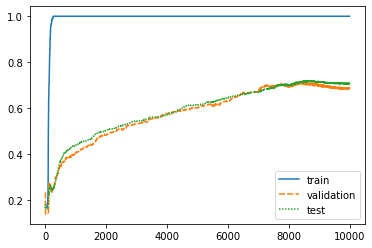

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/CiteSeer/GNN_injected.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.6840
Test Accuracy: 0.7070


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.8128


In [14]:
#5 runs completed
train_acc_all = [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
val_acc_all = [0.6880, 0.6700, 0.6940, 0.6780, 0.6840]
test_acc_all = [0.6890, 0.6890, 0.7040, 0.7050, 0.7070]
test_auc_all = [0.8057, 0.8045, 0.8117, 0.8119, 0.8128]

print(np.mean(train_acc_all))
print(np.mean(val_acc_all))
print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(train_acc_all))
print(np.std(val_acc_all))
print(np.std(test_acc_all))
print(np.std(test_auc_all))

1.0
0.6828000000000001
0.6988
0.8093199999999999
0.0
0.00825590697622008
0.00805977667184396
0.0034862013711201394
